<a href="https://colab.research.google.com/github/springboardmentor891v/HATE_SPEECH_DETECTION_INFOSYS_INTERNSHIP_OCT2024/blob/main/HateSpeechDetection_using_MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Hate Speech Detection Using Machine Learning**

In [ ]:
!pip install pandas scikit-learn nltk matplotlib seaborn

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import warnings
from google.colab import files
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Upload Dataset**

In [2]:
# Upload Raw Dataset
uploaded = files.upload()

# Retrieve the uploaded file path
file_path = list(uploaded.keys())[0]

# Load the raw dataset
df = pd.read_csv(file_path, sep=',', names=['cleaned_text', 'label'], header=0)

# Display the first few rows
print(df.head())


Saving hate_speech_combined_dataset.csv to hate_speech_combined_dataset.csv
                                        cleaned_text  label
0  !!! RT @mayasolovely: As a woman you shouldn't...      1
1    " momma said no pussy cats inside my doghouse "      1
2  "@Addicted2Guys: -SimplyAddictedToGuys http://...      1
3  "@AllAboutManFeet: http://t.co/3gzUpfuMev" woo...      1
4  "@Allyhaaaaa: Lemmie eat a Oreo &amp; do these...      1


# **Dataset Preprocessing**

In [3]:
# Handle Missing Values
df = df.dropna(subset=['label', 'cleaned_text'])  # Drop rows with missing values in either column

# Display dataset info after handling missing values
print(f"Dataset shape after removing missing values: {df.shape}")


Dataset shape after removing missing values: (34621, 2)


In [4]:
# Define Preprocessing Steps
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    # Removing Punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Removing Stop Words
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    # Stemming
    stemmer = PorterStemmer()
    text = ' '.join(stemmer.stem(word) for word in text.split())
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    # Removing Numbers
    text = re.sub(r'\d+', '', text)
    # Removing Whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [5]:
# Apply Preprocessing
df['cleaned_text'] = df['cleaned_text'].astype(str).apply(preprocess_text)

# Display the first few rows after preprocessing
print(df.head())


                                        cleaned_text  label
0  rt mayasolov woman shouldnt complain clean hou...      1
1                 momma said pussi cat insid doghous      1
2  addictedguy simplyaddictedtoguy httptcojlhizmf...      1
3  allaboutmanfeet httptcogzupfumev woof woof hot...      1
4    allyhaaaaa lemmi eat oreo amp dish one oreo lol      1


In [49]:
# Check Class Distribution Before SMOTE
print("Class Distribution Before SMOTE:\n", df['label'].value_counts())


Class Distribution Before SMOTE:
 label
0    26627
1     7994
Name: count, dtype: int64


# **Text Vectorization and SMOTE for Class Imbalance Handling**

In [79]:
# Separate Features and Target
X = df['cleaned_text']  # 'cleaned_text' contains the text data (features)
y = df['label']  # 'label' contains the target variable (class labels: hate speech or non-hate speech)

# Convert text data to numeric features using TF-IDF
# max_features=5000 ensures that only the top 5000 most important features (words) are considered
# ngram_range=(1, 2) considers both unigrams (individual words) and bigrams (pairs of consecutive words)
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = vectorizer.fit_transform(X)  # Apply the transformation to the text data (X)

# Output the shape of the resulting feature matrix (number of samples, number of features)
print("TF-IDF vectorization complete. Shape of X_tfidf:", X_tfidf.shape)


TF-IDF vectorization complete. Shape of X_tfidf: (34621, 5000)


In [80]:
# Apply SMOTE to balance the classes
# SMOTE generates synthetic samples for the minority class to balance the dataset
smote = SMOTE(random_state=42)

# Create a balanced dataset with SMOTE
X_smote, y_smote = smote.fit_resample(X_tfidf, y)

# Print the new class distribution after applying SMOTE
print("\nClass Distribution After SMOTE:\n", pd.Series(y_smote).value_counts())



Class Distribution After SMOTE:
 label
1    26627
0    26627
Name: count, dtype: int64


In [ ]:
# cleaned_df = pd.read_csv('cleaned_balanced_dataset.csv')

Text(0.5, 1.0, 'Distribution of Data After SMOTE')

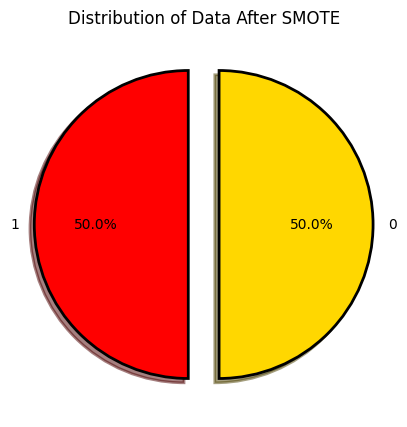

In [77]:
# Create a pie chart to visualize the class distribution after applying SMOTE
fig = plt.figure(figsize=(5,5))  # Set the figure size

# Define pie chart properties
colors = ("red", "gold")  # Segment colors
wp = {'linewidth': 2, 'edgecolor': "black"}  # Wedge properties (style)
explode = (0.1, 0.1)  # Offset slices for emphasis

# Plot the class distribution of the balanced dataset as a pie chart
tags = pd.Series(y_smote).value_counts()  # Count the samples for each class after SMOTE
tags.plot(kind='pie', autopct='%1.1f%%', shadow=True, colors=colors,
          startangle=90, wedgeprops=wp, explode=explode, label='')

# Add a title for context
plt.title('Distribution of Data After SMOTE')


# **Model Training**

Trained the model using ML algorithms: Logistic Regression, Random Forest, K-Nearest Neighbors (KNN), XGBoost, and AdaBoost.

In [81]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state=42)

# Dictionary to store models and their performance
models = {
    "Logistic Regression": LogisticRegression(C=10, multi_class='ovr', solver='lbfgs', random_state=42),
    # "Random Forest": RandomForestClassifier(
    #     n_estimators=300,
    #     max_depth=30,
    #     min_samples_split=5,
    #     min_samples_leaf=2,
    #     random_state=42
    # ),
    "Random Forest": RandomForestClassifier(
    n_estimators=500,       # Increase number of trees for robustness
    max_depth=40,           # Increase depth if the model is underfitting
    min_samples_split=4,    # Try slightly reducing split samples to allow for more splits
    min_samples_leaf=1,     # Allow smaller leaves if the model needs to capture finer details
    random_state=42         # For reproducibility
    ),

    # "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=7),

    "K-Nearest Neighbors": KNeighborsClassifier(
    n_neighbors=9,
    weights='distance',   # Weight the neighbors by distance
    metric='manhattan'    # Try Manhattan distance metric for better results
    ),

    "XGBoost": XGBClassifier(
    n_estimators=150,
    max_depth=12,
    learning_rate=0.05,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42
    ),

    "AdaBoost": AdaBoostClassifier(
    n_estimators=200,
    learning_rate=0.7,
    random_state=42
    )

}

# Training and evaluating models
results = []

for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Using cross-validation to evaluate the model
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean CV score: {cv_scores.mean()}")

    # Fit the model to training data
    model.fit(X_train, y_train)

    # Training accuracy
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)

    # Testing accuracy
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Precision, recall, F1 score on testing data
    precision = precision_score(y_test, y_test_pred)
    recall = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)

    print(f"\n{model_name} Metrics:")
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Testing Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("="*50)

    # Append results for visualization
    results.append({
        "Model": model_name,
        "Training Accuracy": train_accuracy,
        "Testing Accuracy": test_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display results
print(results_df)

Training Logistic Regression...
Cross-validation scores: [0.9397958  0.9397958  0.93920901 0.9379108  0.94096244]
Mean CV score: 0.9395347699387264

Logistic Regression Metrics:
Training Accuracy: 0.9622
Testing Accuracy: 0.9411
Precision: 0.9303
Recall: 0.9536
F1 Score: 0.9418
Training Random Forest...
Cross-validation scores: [0.90271095 0.88710245 0.89449595 0.89542254 0.9       ]
Mean CV score: 0.8959463777147099

Random Forest Metrics:
Training Accuracy: 0.9257
Testing Accuracy: 0.9037
Precision: 0.8979
Recall: 0.9107
F1 Score: 0.9043
Training K-Nearest Neighbors...
Cross-validation scores: [0.66330243 0.67339514 0.67280836 0.6713615  0.67711268]
Mean CV score: 0.67159602098764

K-Nearest Neighbors Metrics:
Training Accuracy: 0.9949
Testing Accuracy: 0.6759
Precision: 0.6073
Recall: 0.9944
F1 Score: 0.7540
Training XGBoost...
Cross-validation scores: [0.88815867 0.8795916  0.88111724 0.8721831  0.88086854]
Mean CV score: 0.880383829401319

XGBoost Metrics:
Training Accuracy: 0.893

In [82]:
import joblib

# Save the vectorizer
joblib.dump(vectorizer, "X_tfidf_vectorizer.pkl")


['X_tfidf_vectorizer.pkl']

# **Results**

In [83]:
# Create a separate cell to display accuracy metrics as percentages
accuracy_metrics = results_df[["Model", "Training Accuracy", "Testing Accuracy"]]

# Convert the accuracy columns to percentages
accuracy_metrics["Training Accuracy"] = accuracy_metrics["Training Accuracy"] * 100
accuracy_metrics["Testing Accuracy"] = accuracy_metrics["Testing Accuracy"] * 100

# Print the results as percentages
accuracy_metrics = accuracy_metrics.round({"Training Accuracy": 2, "Testing Accuracy": 2})
print(accuracy_metrics)


                 Model  Training Accuracy  Testing Accuracy
0  Logistic Regression              96.22             94.11
1        Random Forest              92.57             90.37
2  K-Nearest Neighbors              99.49             67.59
3              XGBoost              89.36             88.80
4             AdaBoost              88.28             88.47


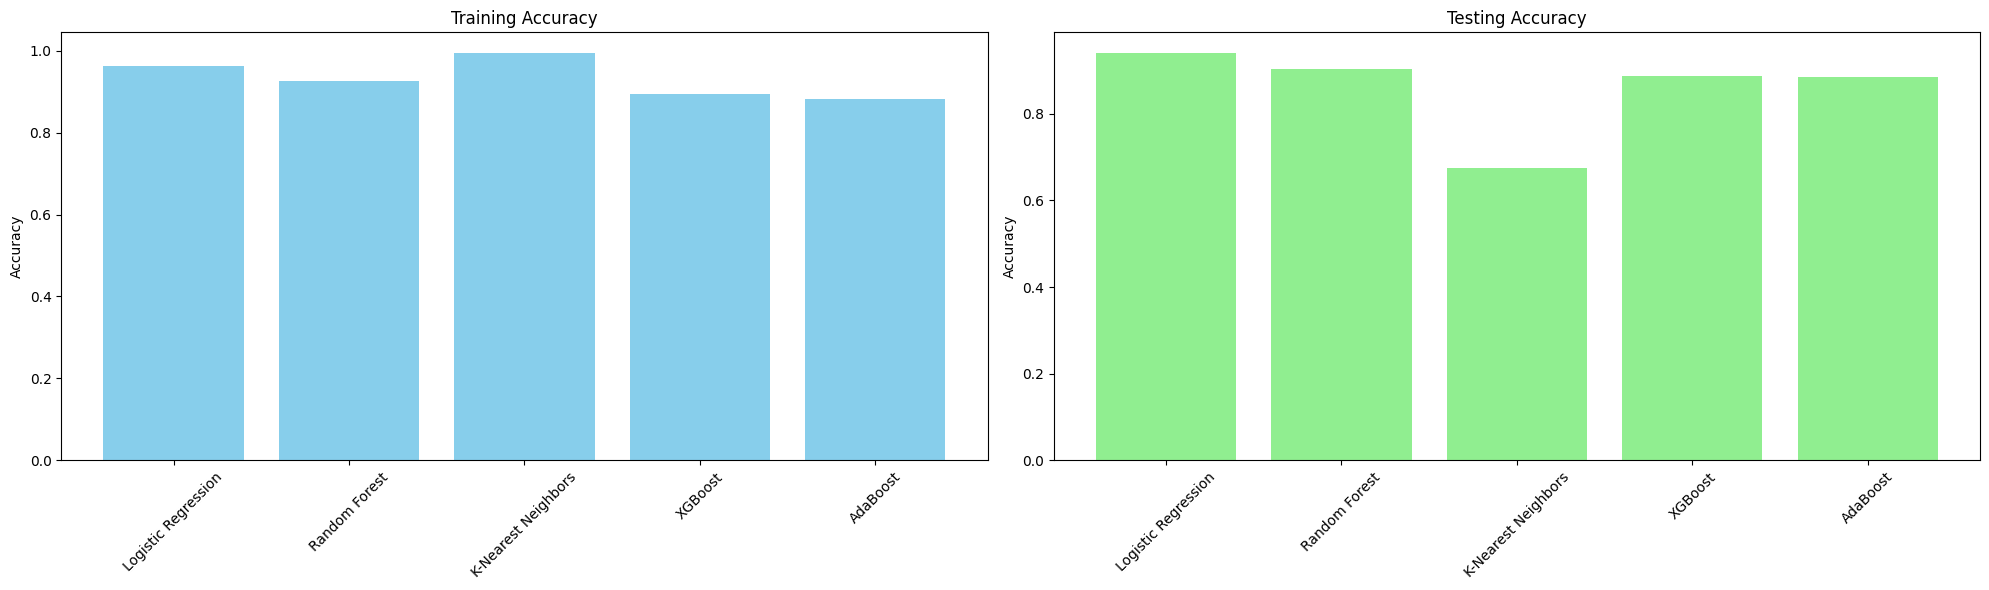

In [84]:
# Set up figure and axes
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the training accuracy
axes[0].bar(results_df["Model"], results_df["Training Accuracy"], color="skyblue")
axes[0].set_title("Training Accuracy")
axes[0].set_ylabel("Accuracy")
axes[0].set_xticklabels(results_df["Model"], rotation=45)

# Plot the testing accuracy
axes[1].bar(results_df["Model"], results_df["Testing Accuracy"], color="lightgreen")
axes[1].set_title("Testing Accuracy")
axes[1].set_ylabel("Accuracy")
axes[1].set_xticklabels(results_df["Model"], rotation=45)


# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

# **Identify the Best Model**

In [86]:
# Identify the best model based on testing accuracy
best_model = results_df.loc[results_df['Testing Accuracy'].idxmax()]

# Convert the accuracy columns to percentages for the best model
best_model["Training Accuracy"] = best_model["Training Accuracy"] * 100
best_model["Testing Accuracy"] = best_model["Testing Accuracy"] * 100
best_model["Precision"] = best_model["Precision"] * 100
best_model["Recall"] = best_model["Recall"] * 100
best_model["F1 Score"] = best_model["F1 Score"] * 100

# Round the results to two decimal places and format as percentages
best_model = best_model.round({"Training Accuracy": 2, "Testing Accuracy": 2,
                                "Precision": 2, "Recall": 2, "F1 Score": 2})

# Format the values as percentages and display the best model
best_model_display = best_model.apply(lambda x: f"{x:.2f}%" if isinstance(x, (int, float)) else x)

# Print the best model with accuracy metrics as percentages
print("\nBest Model Based on Testing Accuracy:")
print(best_model_display)



Best Model Based on Testing Accuracy:
Model                Logistic Regression
Training Accuracy                 96.22%
Testing Accuracy                  94.11%
Precision                         93.03%
Recall                            95.36%
F1 Score                          94.18%
Name: 0, dtype: object


# **Confusion Matrix of Best Model**

The confusion matrix is a 2x2 matrix:

 [[TN, FP],
  [FN, TP]]

Where:

TN: True Negatives (correctly classified as "Non-Hate Speech")

FP: False Positives (incorrectly classified as "Hate Speech")

FN: False Negatives (incorrectly classified as "Non-Hate Speech")

TP: True Positives (correctly classified as "Hate Speech")


<Figure size 800x600 with 0 Axes>

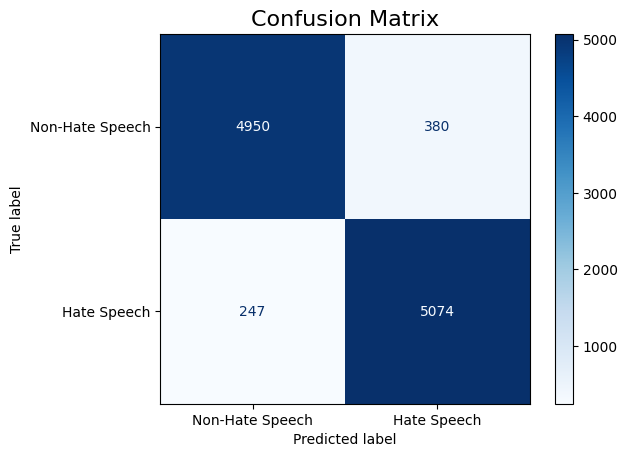

In [87]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate predictions for the test set

y_pred = models["Logistic Regression"].predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hate Speech", "Hate Speech"])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix", fontsize=16)

plt.show()


# **Save the Best Model**

In [88]:
# Save the best model
best_model_name = best_model['Model']
final_model = models[best_model_name]
print(f"Saving the best model: {best_model_name}")
import joblib
joblib.dump(final_model, "best_model_logistic_regression.pkl")

Saving the best model: Logistic Regression


['best_model_logistic_regression.pkl']

# **Test the model with User Input**

In [97]:
# Testing with user input

import joblib
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# Load the saved model and vectorizer
final_model = joblib.load("best_model_logistic_regression.pkl")
vectorizer = joblib.load("X_tfidf_vectorizer.pkl")  # Load the actual vectorizer object


# Input text from the user
user_input = input("Enter the text to classify: ")

# Preprocess the input text
user_input_cleaned = preprocess_text(user_input)

# Vectorize the cleaned input using the loaded TF-IDF vectorizer
user_input_vectorized = vectorizer.transform([user_input_cleaned]).toarray() # Now this should work

# Predict using the loaded model
prediction = final_model.predict(user_input_vectorized)

# Output classification result
if prediction[0] == 1:
    print("The input text is classified as Non-Hate Speech.")
else:
    print("The input text is classified as Hate Speech.")

Enter the text to classify: hello world
The input text is classified as Non-Hate Speech.
